## Importing the dependencies

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
%matplotlib inline

## Importing the data

In [12]:
raw_data = pd.read_csv('../sample_data/influentdata.csv',sep=';')
raw_data.datetime = pd.to_datetime(raw_data.datetime)
raw_data.set_index('datetime', inplace=True, drop=True)
#raw_data = raw_data.asfreq('2 min')
df = raw_data['01 January 2018':'01 February 2018'].copy()

Parameters are ['CODf', 'COD', 'NH4_N', 'K']


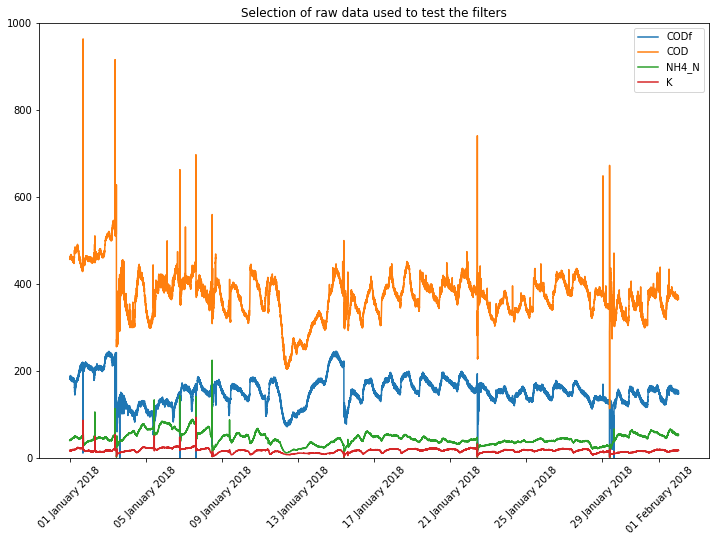

In [24]:
import matplotlib.dates as mdates
parameters_list = []
for column in df.columns:
    if (('Unit' not in column) & ('equipment' not in column)):
        parameters_list.append(column)
print('Parameters are {}'.format(parameters_list))
fig, ax = plt.subplots(figsize=(12,8))
#plt.figure(figsize=(12,8))
for parameter in parameters_list:
    ax.plot(df.index, df[[parameter]])     
plt.xticks(rotation=45)
day_month_year_Fmt = mdates.DateFormatter('%d %B %Y')
ax.xaxis.set_major_formatter(day_month_year_Fmt)
ax.set_ylim([0, 1000])
plt.legend(parameters_list)
plt.title('Selection of raw data used to test the filters')
plt.show()

## Creating a dictionnary to store filter parameters

In [26]:
param = { ### parameters with default values
    'nb_s':1.25,
    'nb_reject':100,
    'nb_backward':15,
    'MAD_ini':10, #Mean absolute distance
    'min_MAD':0,
    'ShowStats':True,
    'Verbose':True,
    'DT_RelRol':0.01,
    'restart':True,
    'h_smoother':30,
    'N_Reset':2,
    'lambda_z':None,
    'lambda_MAD':None,
}
paramX = {  #### params to set for each sensor / time series
    'corr_max':None,
    'corr_min':None,
    'slope_max':None,
    'slope_min':None,
    'std_max':None,
    'std_min':None,
    'range_max':None,
    'range_min':None
}

## Outlier detection

In [27]:
#DATA : Time serie with the time and its corresponding value
#ALPHA_Z and ALPHA_MAD : Smoothing parameters

K = param['nb_s'] # /**/!!!!! : Number of standard deviation unit used for the calculation of the prediction interval
MAD_ini = param['MAD_ini'] # Initial mean absolute deviation used to start or reinitiate the outlier detection method
nb_reject = param['nb_reject'] # Number of consecutive rejected data needed to reinitiate
#the outlier detection method.  When nb_reject data are rejected, this is called an out-of-control.
nb_backward = param['nb_backward'] # Number of data before the last rejected data(the last of nb_reject data) where the outlier detection method is reinitialization for a forward application.
alpha_z    = param['lambda_z']
alpha_MAD  = param['lambda_MAD']
min_MAD    = param['min_MAD']

## Using the Time series analysis library

In [28]:
from statsmodels.tsa import holtwinters

In [29]:
col='COD'

In [30]:
model = holtwinters.ExponentialSmoothing(df[col].values) #trend='add', damped=True)
res = model.fit()
param['lambda_z'] = res.params['smoothing_level']
alpha_z = param['lambda_z']

In [31]:
def shift(xs, n):
    if n >= 0:
        return np.concatenate((np.full(n, np.nan), xs[:-n]))
    else:
        return np.concatenate((xs[-n:], np.full(-n, np.nan)))

In [32]:
df[col+'_forecast'] = res.fittedfcast[:-1]
df[col+'_err'] = df[col+'_forecast']-df[col]
df[[col, col+'_forecast', col+'_err']].head()

,COD,COD_forecast,COD_err
datetime,,,
2018-01-01 00:00:00,457.873,457.931420,0.058420
2018-01-01 00:02:00,459.420,457.896066,-1.523934
2018-01-01 00:04:00,459.028,458.818304,-0.209696
2018-01-01 00:06:00,462.393,458.945206,-3.447794
2018-01-01 00:08:00,458.756,461.031705,2.275705


In [33]:
model_error = holtwinters.ExponentialSmoothing(abs(df[col+'_err'].values))
result_error = model_error.fit()

param['lambda_MAD'] = result_error.params['smoothing_level']
alpha_MAD = param['lambda_MAD']
param['MAD_ini'] = result_error.params['initial_level']
MAD_ini = param['MAD_ini']


df[col+'_predicted_err'] = result_error.fittedfcast[:-1]

param['min_MAD'] = np.median(df[col+'_predicted_err'])
min_MAD = param['min_MAD']

print('min_MAD: {} \nMAD_ini: {} \nalpha_MAD: {}'.format(min_MAD, MAD_ini, alpha_MAD))

min_MAD: 2.7108846857747766 
MAD_ini: 0.9546443584747184 
alpha_MAD: 0.409977965547058


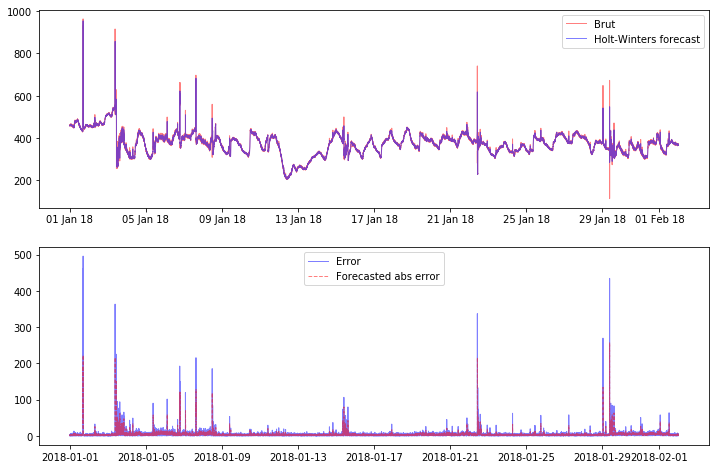

In [34]:
from matplotlib import dates as mdates
fig, axes = plt.subplots(figsize=(12,8),nrows=2, ncols=1)
plt.rc('lines', linewidth=1)

ax = axes.flatten()[0]
ax.plot(df[col],c='r', alpha=0.5)
ax.plot(df[col+'_forecast'],c='b', alpha=0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %y'))
ax.legend(['Brut','Holt-Winters forecast'])

ax2 = axes.flatten()[1]
ax2.plot(abs(df[col+'_err']),'b', linestyle='-',alpha=0.5)
ax2.plot(df[col+'_predicted_err'],linestyle='dashed',c='r', alpha=0.5)
ax2.legend(['Error','Forecasted abs error'])
plt.show()

In [38]:
df[col+'_s'] = np.nan
df[col+'_MAD'] = np.nan
df[col+'_ll'] = np.nan
df[col+'_ul'] = np.nan
df[col+'_outlier'] = np.nan
df[col+'_accepted'] = np.nan
a=[]
for column in df.columns:
    if 'COD' in column:
        a.append(column)
print(a)

['CODf', 'CODf Unit', 'CODf equipment', 'COD', 'COD Unit', 'COD equipment', 'COD_forecast', 'COD_err', 'COD_predicted_err', 'COD_s', 'COD_MAD', 'COD_ll', 'COD_ul', 'COD_outlier', 'COD_accepted']


In [39]:
print(MAD_ini)

0.9546443584747184


In [55]:
df.columns.get_loc('COD_MAD')

16

In [60]:
cols={}
for i in range(len(df.columns.values)):
    cols[df.columns.values[i]]=i
    
df.iloc[0, cols[col+'_s']] = 1.25*MAD_ini
df.iloc[0, cols[col+'_ll']] = df[col+'_forecast'].iloc[0] - K * df[col+'_s'].iloc[0]
df.iloc[0, cols[col+'_ul']] = df[col+'_forecast'].iloc[0] + K * df[col+'_s'].iloc[0]

In [61]:
K=3
for i in range(len(df)-1):
    if (df.iloc[i, cols[col]] < df.iloc[i, cols[col+'_ul']]) and (df.iloc[i, cols[col]] > df.iloc[i, cols[col+'_ll']]):
        df.iloc[i, cols[col+'_accepted']] = df[col].iloc[i]
        df.iloc[i, cols[col+'_outlier']] = 0
        
        df.iloc[i+1, cols[col+'_MAD']] = max([abs(alpha_MAD*(df.iloc[i, cols[col+'_accepted']]-df.iloc[i, cols[col+'_forecast']]))+\
                                       (1-alpha_MAD)*df.iloc[i, cols[col+'_MAD']], min_MAD])
        df.iloc[i+1, cols[col+'_s']] = 1.25*df.iloc[i, cols[col+'_MAD']]

    else:
        df.iloc[i, cols[col+'_accepted']] = df.iloc[i, cols[col+'_forecast']]
        df.iloc[i, cols[col+'_outlier']] = 1
        
        df.iloc[i+1, cols[col+'_MAD']] = max([df.iloc[i, cols[col+'_MAD']], min_MAD])
        
        df.iloc[i+1, cols[col+'_s']] = df.iloc[i, cols[col+'_s']]
        
    df.iloc[i+1, cols[col+'_ll']] = df.iloc[i, cols[col+'_forecast']] - K * df.iloc[i+1, cols[col+'_s']]
    df.iloc[i+1, cols[col+'_ul']] = df.iloc[i, cols[col+'_forecast']] + K * df.iloc[i+1, cols[col+'_s']]

In [121]:
b = df[col+'_accepted'].iloc[0:100]

(2.983263620233515, 2.983263620233515, 2.983263620233515)

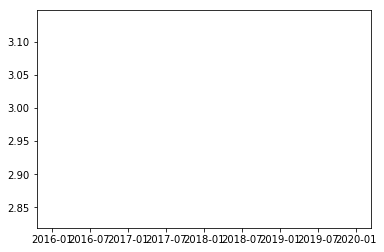

In [65]:
plt.plot(df[col+'_ul']-df[col+'_ll'])
a=df[col+'_ul']-df[col+'_ll']
a.mean(), a.min(), a.max()

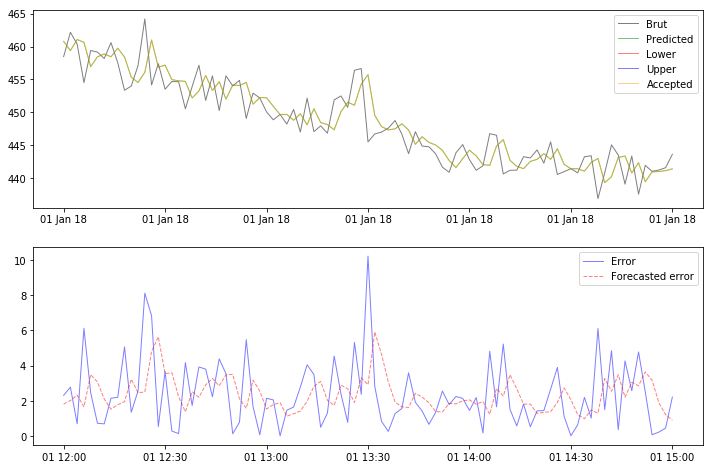

In [64]:
from matplotlib import dates as mdates
fig, axes = plt.subplots(figsize=(12,8),nrows=2, ncols=1)

plt.rc('lines', linewidth=1)
s='January 1 2018 12:00:00'#df.first_valid_index()
e='JANUARY 1 2018 15:00:00'#df.last_valid_index()
ax = axes.flatten()[0]
ax.plot(df.loc[s:e, col], c='k', alpha=.5)
ax.plot(df.loc[s:e, col+'_forecast'], c='g', alpha=.5)
ax.plot(df.loc[s:e, col+'_ll'], c='r', alpha=.5)
ax.plot(df.loc[s:e, col+'_ul'], c='b', alpha=.5)
ax.plot(df.loc[s:e, col+'_accepted'],c='orange', alpha=.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %y'))
ax.legend(['Brut','Predicted','Lower','Upper','Accepted'])

ax2 = axes.flatten()[1]
ax2.plot(abs(df.loc[s:e, col+'_err']),'b', linestyle='-',alpha=0.5)
ax2.plot(df.loc[s:e, col+'_predicted_err'],linestyle='dashed',c='r', alpha=0.5)
ax2.legend(['Error','Forecasted error'])
plt.show()

## Porting over the matlab scripts as dirtectly as possible

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
%matplotlib inline

In [25]:
raw_data = pd.read_csv('../sample_data/influentdata.csv',sep=';')
raw_data.datetime = pd.to_datetime(raw_data.datetime)
raw_data.set_index('datetime', inplace=True, drop=True)
#raw_data = raw_data.asfreq('2 min')
df = raw_data.loc['15 January 2018':'15 February 2018',['COD']].copy()

Parameters are ['COD']


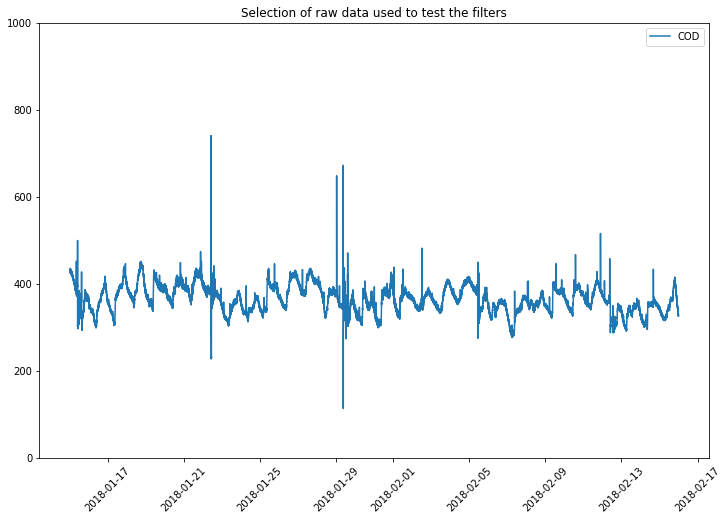

In [26]:
parameters_list = []
for column in df.columns:
    if (('Unit' not in column) & ('equipment' not in column)):
        parameters_list.append(column)
print('Parameters are {}'.format(parameters_list))
plt.figure(figsize=(12,8))
for parameter in parameters_list:
    plt.plot(df.index, df[[parameter]])     
plt.xticks(rotation=45)
plt.ylim([0, 1000])
plt.legend(parameters_list)
plt.title('Selection of raw data used to test the filters')
plt.show()

In [76]:
df_arr =df[['COD']]
arr=np.array(df_arr).flatten()
print(arr)
df_arr.columns[0]

[429.827 425.971 429.146 ... 325.974 326.467 327.033]


'COD'

In [110]:
a=np.array([1,2,3,4,5])
b=np.array([4,7,2,5,8])
print(((b-a)**2/len(a)).sum())

9.0


In [59]:
df2 = df.asfreq('2 min')
Time = pd.Series(df2.index.astype('int64')/10**9)
df2 =df2.fillna(method='ffill')
print(df2['COD'].isnull().sum())
dt = Time.diff().dropna()
print(np.median(dt), dt.max(), dt.min())

0
120.0 120.0 120.0


In [10]:
def DefaultParam(method):
    if method not in ['Online_EWMA']:
        raise Exception('NotImplemented_Error: Only "Online_EWMA" implemented so far')
    function param = DefaultParam(OutlierDetectionMethod)
% This function generates a default param structure holding all required
% parameters for the filter. It is possible to modify any parameter here,
% but we strongly suggest to keep this script untouched and to update
% manually the parameters in your own Main script. For example, the two
% following lines of code initialize all parameters and update only the
% parameter NB_REJECT:
%   >> DefaultParam;
%   >> param.nb_reject = 80;

% Three outlier detection methods are currently available: 
%   - Online_EWMA (default), based on Janelcy's work
%   - EWMA: a simple exponentially weighted moving average without recovery
%           algorithm
%   - NeuralNetwork: An experimental approach through neural networks to
%           detect unpredictable datapoints.
% At the moment, defaults parameters are provided for Online_EWMA only.
if strcmp(OutlierDetectionMethod, 'Online_EWMA')
    param.OutlierDetectionMethod = 'Online_EWMA';
    
      
    % Multiplicative factor that drives calculation of the prediction interval.
    % At each time step, the confidence interval is computed as
    %    Forecast +/- [nb_s * 1.25 * Mean_Absolute_Deviation]
    % In other words, a large value of nb_s (i.e. nb_s = 10) accepts most datapoints and rejects
    % only the most obvious outliers while a small value of nb_s (i.e. nb_s = 1) is much more
    % restrictive.
    param.nb_s          = 3;   

    % Number of consecutive rejected data needed to reinitialization the 
    % outlier detection method.  If nb_reject data are reject this is called an 
    % out of control.
    param.nb_reject     = 100;  

    % Number of data before the last rejected data (the last of nb_reject data) 
    % where the outlier detection method is reinitialization for a forward 
    % application. 
    param.nb_backward   = 15;

    % Mean absolute deviation used to start and reinitialization the outlier 
    % detection method
    param.MAD_ini       = 10;

    % Minimum mean absolute deviation to be used. If the computed MAD falls
    % below, it is replaced by min_MAD. A specific example of this
    % occurence is if a constant value appears in the time series. Under
    % this circumstance and without a min_MAD value, the MAD will fall to
    % zero and all datapoint different from the constant will be flag as
    % outlier until the next restart.
    % The default value of 0 means that min_MAD will be initialized in the
    % ModelCalibration function.
    param.min_MAD       = 0;

    % The smoother parameter defines how much datapoints are used to smooth a
    % specific value. Datapoints between [i-h_smoother : i+h_smoother] are used
    % in the weighting formula. If h_smoother == 0, an automatic calibration of
    % the parameter is attempted (not tested by CG... yet).
    param.h_smoother    = 5;

    % Show some statistics about the filtering process
    param.ShowStats = true;

    % Displays some warning and error messages when TRUE. 
    param.Verbose = true;

    % Permitted variation of the timestep to be considered constant. is the
    % variation between a timestep and the median timestep is smaller than the
    % parameter, the timestep is considered constant. Otherwise, it is
    % considered variable and must be used with caution: the filter currently
    % assumes a constant timestep.
    param.DT_RelRol = 0.01;

    % Set to TRUE if the filtering must be restarted from scratch. If set to
    % FALSE, a sequential filtering is performed and new filtered data is
    % either appended to existing one or replaces it.
    param.restart = true;


    % If a serie of data is refiltered, the exponential moving average filter
    % must be applied to a number of datapoints in the so-called warmup period.
    % The period of the filter is defined by N in the equation: 
    %           ALPHA = 1/(1+N).
    % In theory, 86% of the warmup is done after N datapoints are filtered. To
    % get closer to 100%, the parameter N_Reset allows to use more than one
    % period, thus more datapoints based on the calibrated parameter ALPHA.
    % No value larger than 4 or 5 should be used, since no improvement can be
    % observed. 
    param.N_Reset = 2;
       
elseif strcmp(OutlierDetectionMethod, 'NeuralNetwork')
    param = SetparamNN;
    param.lambda  = 0.2;
    param.sigma   = 3;

    param.OutlierDetectionMethod = 'NeuralNetwork';
elseif strcmp(OutlierDetectionMethod, 'EWMA')
    param.lambda = 0.2;
    param.sigma = 3;
    param.OutlierDetectionMethod = 'EWMA';
else
    error(['Unknown outlier detection method: ' OutlierDetectionMethod]);
end

%Parameters for the fault detection method: 

%Definition of window for the run_test test of the fault detection:
param.moving_window = 1000;

%Definition reading interval: 
param.reading_interval = 5; % Value chose by RP. Can be changed. 


%This parameter allows to 
paramX_aff.mobilerange = NaN;

%Definition of window for the mobilerange test of the fault detection
paramX_aff.mobilewindow =NaN;

%This parameter allows to select the difference of y. This one is
%differente about each sensor. 
paramX_aff.dy = NaN;


%Definition of Range (Max and Min): These one will be decided by the
%operator
param.range_min = NaN;
param.range_max = NaN;

%Limit for the whole data feature calculation. For now, every limit (Min and Max) are equal to NaN because it's the operator 
%who will decide of these limits. 

param.corr_min= NaN;  
param.corr_max= NaN;

param.slope_min= NaN;  
param.slope_max= NaN;   

param.std_min= NaN; 
param.std_max= NaN; 

param.range_min= NaN; 
param.range_max= NaN;




In [11]:
DefaultParam('x')

Exception: NotImplemented_Error: Only "Online_EWMA" implemented so far

In [ ]:
def triple_smoothing(data_array):
    import scipy.optimize
    param,cov =scipy.optimize.curve_fit(s_1, data_array[1:], shift(data_array,1)[1:])
    alpha_1 = param[0]
    first_order = s_1(data_array, alpha_1)
    
    param,cov =scipy.optimize.curve_fit(s_2, data_array[2:], shift(data_array,2)[2:])
    alpha_2 = param[0]
    second_order = s_2(data_array, alpha_2)
    
    param,cov =scipy.optimize.curve_fit(s_3, data_array[3:], shift(data_array,3)[3:])
    alpha_3 = param[0]
    third_order = s_3(data_array, alpha_3)
    print(alpha_1, alpha_2, alpha_3)
    return np.add(np.add(first_order, second_order), np.dot(third_order,0.5))

## Formatting data to conform to the datEAUbase export format

In [ ]:
def backtodateaubase_format(input_df, param,sampling_point):
    df = input_df.copy(deep=True)
    df = df[['datetime',param,param+' Unit', param+' equipment']]
    df['Sampling Point'] = sampling_point
    df[param+' equipment'] = param +' from '+ df[param+' equipment']
    df.columns = ['Date and Time', 'Value', 'Unit', 'Parameter / from','Sampling point']
    df=df[['Date and Time','Sampling point','Parameter / from','Value','Unit']]
    return df

In [ ]:
params_list = ['CODf','COD','NH4_N','K']
sampling_point = 'Primary settling tank effluent'

def stackparams(df_input, params_list, sampling_point):
    df_list = []
    for param in params_list:
        df_list.append(backtodateaubase(df_input,param,sampling_point))
    df = pd.concat(df_list, ignore_index=True)
    return df


In [ ]:
test2 = stackparams(raw_data,params_list,sampling_point)
print(len(test2))

In [ ]:
test2.set_index('Date and Time', drop=True, inplace=True)

In [ ]:
test2.to_csv('unfiltered_data.csv',sep=';')

In [ ]:
test2.head()

In [ ]:
print(test2[test2['Parameter / from']=='COD from Spectro_010'].first_valid_index())
print(test2[test2['Parameter / from']=='COD from Spectro_010'].last_valid_index())

In [ ]:
tr_data = raw_data.copy(deep=True) 
tr_data['parameter']

In [ ]:
parameters_list = []
for column in raw_data.columns:
    if (('Unit' not in column) & ('equipment' not in column)):
        parameters_list.append(column)
print(parameters_list)
for parameter in parameters_list:
    plt.plot(raw_data.index, raw_data[[parameter]])     
plt.legend(parameters_list)
plt.show()